import modules

In [51]:
# @title imports
from typing import Callable, List, Tuple
import sys
sys.path.insert(0, '../abc')
import torch as t
from torch.distributions import normal, uniform
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from IPython import display
from tqdm import tqdm
import time
from abc_rej import abc_rej
from abc_mcmc import abc_mcmc
from abc_prc import abc_prc
from model import init_grids, model
from vis_utils import visualize_batch, visualize_sequence
from utils import chop_and_shuffle_data
from helpers import gaussian_pdf

# Finding $\beta$ for a set of observations using approximate Bayesian computation

## Summary statistics for the PCA

In order to perform ABC, we need to define a set of summary statistics $S(.)$ for the samples produced by the PCA model. Here, we have to make a few choices that will impact the performance of the ABC algorithms.

Our dataset $D = \{x_i, y_i\}_{i=1}^N$ consists of $N$ pairs of grid states. Each pair represents the transition of a grid from a state $x_i$ to a state $y_i$. The PCA model takes as input a grid state, simulates a time step for it, and returns the resulting state.

**1. Count the number of newly activated cells**

Our first summary statistic can be to simply count the number of cells transitioning from $x_{ij}^{(n)}= 0$ to $y_{ij}^{(n)}= 1$ for $n=1,\dots,N$ and sum up the result

**2. Collect the indices of the newly activated cells**

The second possible statistic is a collection of the indices of all cells that have changed state between $x_{ij}$ and $y_{ij}$. This allows e.g. to define the distance function as a pixel-wise loss function. 



In [6]:
# @title define summary statistics functions
def S1(X:t.Tensor, Y:t.Tensor) -> float:
  return t.sum((1-X)*Y, axis=(-1,-2))

def S2(X:t.Tensor, Y:t.Tensor) -> float:
  return (1-X)*Y

To test the functions, we can define a toy example transition:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

In [8]:
x_t = t.zeros((1,3,3))
x_t[0,1,1] = 1
x_tt = t.zeros((1,3,3))
x_tt[0,:,1] = 1
x_tt[0,2,2] = 1

print(f"S1(x_t, x_tt) = {S1(x_t, x_tt)}")
print(f"S2(x_t, x_tt) = \n{S2(x_t, x_tt)}")

S1(x_t, x_tt) = tensor([3.])
S2(x_t, x_tt) = 
tensor([[[0., 1., 0.],
         [0., 0., 0.],
         [0., 1., 1.]]])


## Distance functions

In order to perform ABC, we need to define a distance function $\rho(S(x_{sim}), S(x_{obs}))$ based on the summary statistics $S(.)$:

In [9]:
def calc_distance(X, Y_sim:np.ndarray, Y_obs:np.ndarray) -> float:
  # get statistics of the simulated set
  s_sim = S1(X, Y_sim)
  # get statistics of the observed set
  s_obs = S1(X, Y_obs)
  # calculate the mean ratio
  return (1 - t.mean(s_sim / (s_obs+1)))**2

We can again visualize the distance function by giving a toy example where starting from the same input $x_t$ we observe three different outcomes $x^1, x^2, x^3$. We can determine how similar these transitions are to each other through the distance function.

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}
$$

$$
x_{t+1}^1 = 
\begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{pmatrix},
x_{t+1}^2
\begin{pmatrix}
0 & 1 & 1 \\
0 & 1 & 0 \\
1 & 1 & 1 
\end{pmatrix},
x_{t+1}^3
\begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$


In [16]:
x_t = t.zeros((1,3,3))
x_t[0,1,1] = 1

x1_tt = t.zeros((1,3,3))
x1_tt[0,1,1] = 1
x1_tt[0,2,2] = 1

x2_tt = t.zeros((1,3,3))
x2_tt[0,:,1] = 1
x2_tt[0,2,0] = 1
x2_tt[0,0,2] = 1
x2_tt[0,2,2] = 1

x3_tt = t.zeros((1,3,3))
x3_tt[0,:,1] = 1
x3_tt[0,2,2] = 1

print(f"The distance between x1 and x2 is: {calc_distance(x_t, x1_tt, x2_tt)}")
print(f"The distance between x1 and x3 is: {calc_distance(x_t, x1_tt, x3_tt)}")
print(f"The distance between x2 and x3 is: {calc_distance(x_t, x2_tt, x3_tt)}")

The distance between x1 and x2 is: 0.6944444179534912
The distance between x1 and x3 is: 0.5625
The distance between x2 and x3 is: 0.0625


## Experiment 1: Dataset generated from a single $\beta$ value

### 1. Generating the Dataset

set hyperparameters:

In [18]:
grid_size = 9 
num_sequences = 100 
steps_per_sequence = 20 
beta = t.tensor(0.08) 

frame_speed = 0.1 

visualize an example sequence

In [24]:
grids = init_grids(grid_size, 2)
for i in range(steps_per_sequence):
  visualize_batch(grids)
  display.display(plt.gcf())
  grids = model(grids, beta)
  display.clear_output(wait=True)
  time.sleep(frame_speed)

<Figure size 432x288 with 0 Axes>

generate the data

In [ ]:
sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
batch = init_grids(grid_size,num_sequences)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch
  batch = model(batch, beta)
  
visualize_sequence(sequences[np.random.randint(0,num_sequences)], framerate=0.1)
dataset = chop_and_shuffle_data(sequences)
print(dataset.shape)

In [28]:
X = dataset[:,0]
Y_obs = dataset[:,1]
Y_sim = model(X, 0.08)
calc_distance(X, Y_sim, Y_obs)

tensor(0.0214, dtype=torch.float64)

### Estimate $\beta$ via ABC-REJ

We define:

- $\epsilon = 0.1$ 
- $p(\theta) \sim U(0,1)$

run the algorithm

In [30]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}
samples = []
required_steps = []
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1
prior = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1000)):
  sample, num_steps = abc_rej(X, Y_obs, epsilon, prior, model, calc_distance)
  samples.append(sample)
  required_steps.append(num_steps)

print(f"\n average # steps for acceptance: {np.mean(required_steps)}")




100%|██████████| 1000/1000 [01:09<00:00, 14.40it/s]


 average # steps for acceptance: 14.424


visualize results:

[Text(0.5, 0, 'beta')]

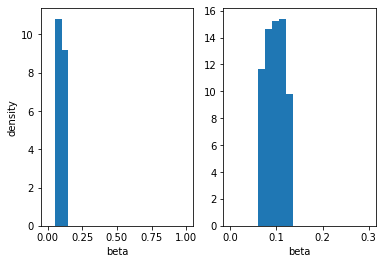

In [41]:
fig, axs = plt.subplots(1,2)
axs[0].hist(t.tensor(samples), density=True, range=(0,1), bins=20)
axs[0].set(xlabel="beta", ylabel="density")
axs[1].hist(t.tensor(samples), density=True, range=(0,0.3), bins=20)
axs[1].set(xlabel="beta")

### Estimate $\beta$ via ABC-MCMC

We define:

- $\epsilon = 0.1$ 
- $\beta_0 = 0.5$
- $q(\theta|\theta_t) \sim \mathcal{N}(\theta_t, 0.15^2)$


define helpers:

In [45]:
sigma = t.tensor(0.15)


def q(theta: t.Tensor):
    return normal.Normal(theta, sigma).sample()


def gauss_likelihood(x: t.Tensor, y: t.Tensor) -> t.Tensor:
    pdf = gaussian_pdf(y, sigma**2)
    return pdf(x)


def uniform_likelihood(low: float, high: float, x: t.Tensor) -> float:
    if x > high or x < low:
        return 0
    else:
        return 1 / (high - low)


def calc_alpha(
    theta_star: t.Tensor, theta: t.Tensor, epsilon: float, dist: t.Tensor
) -> t.Tensor:
    if dist <= epsilon and uniform_likelihood(-10, 10, theta_star) > 0:
        ratio = gauss_likelihood(theta, theta_star) / gauss_likelihood(
            theta_star, theta
        )
        return t.min(t.tensor([t.tensor(1.0), ratio]))
    else:
        return t.tensor(0.0)


100%|██████████| 10000/10000 [00:53<00:00, 186.12it/s]


accepted 1714 samples


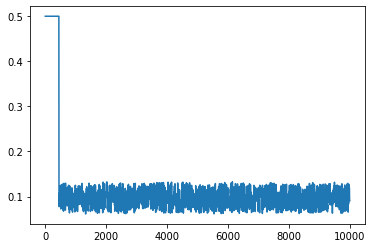

In [46]:
# @title Run ABC-MCMC for the example { vertical-output: true}
N = 10000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1
beta_init = t.tensor(0.5)

betas, beta_hist, step_hist = abc_mcmc(X, Y_obs, beta_init, model, calc_distance, calc_alpha, epsilon, q, N)

print(f"accepted {len(betas)} samples")

plt.plot(np.arange(len(beta_hist)), beta_hist)

[Text(0.5, 0, 'beta')]

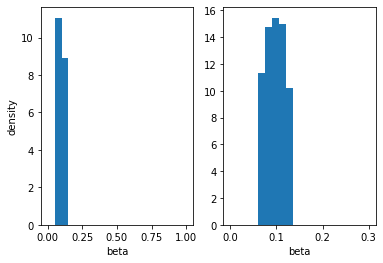

In [50]:
fig, axs = plt.subplots(1,2)
axs[0].hist(betas, density=True, range=(0,1), bins=20)
axs[0].set(xlabel="beta", ylabel="density")
axs[1].hist(betas, density=True, range=(0,0.3), bins=20)
axs[1].set(xlabel="beta")

### Estimate $\beta$ via ABC-PRC

In [62]:
def visualize_results(beta_hist:List[t.Tensor], xlim=1) -> None:
  """
  Visualize the results of the ABC-PRJ algorithm.
  """
  fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

  axs[0,0].hist(beta_hist[0], density=True, bins=20)
  axs[0,0].set(ylabel='density', title="Population 0")
  axs[0,1].hist(beta_hist[1], density=True, bins=20)
  axs[0,1].set(title="Population 1")
  axs[1,0].hist(beta_hist[2], density=True, bins=20)
  axs[1,0].set(xlabel='theta', ylabel='density', title="Population 2")
  axs[1,1].hist(beta_hist[3], density=True, bins=8)
  axs[1,1].set(xlabel='theta', title="Population 3")

  plt.xlim(0,xlim)
  plt.show()

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 3/3 [01:03<00:00, 21.29s/it]


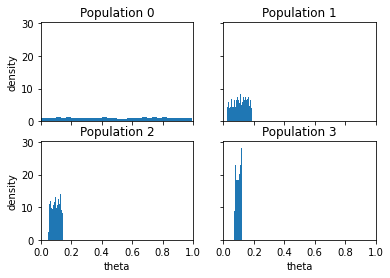

In [53]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 1000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05]
mu_1 = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample_n

def kernel(beta:t.Tensor):
    return normal.Normal(beta, 0.1).sample()

betas, beta_hist = abc_prc(X, Y_obs, model, mu_1, kernel, calc_distance, epsilons, N)

visualize_results(beta_hist)

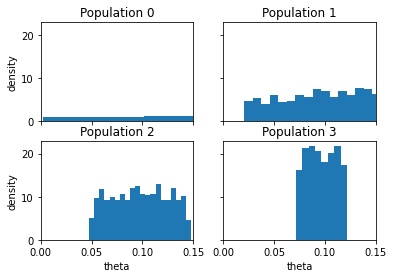

In [63]:
visualize_results(beta_hist, xlim=0.15)

## Experiment 2: Generating a dataset from a distribution of $\beta$ values



set hyperparameters

In [64]:
grid_size = 30 
num_sequences = 100
steps_per_sequence = 20 
mu = t.tensor(0.5) 
sigma = t.tensor(0.1) 

frame_speed = 0.1 

visualize the distribution over beta

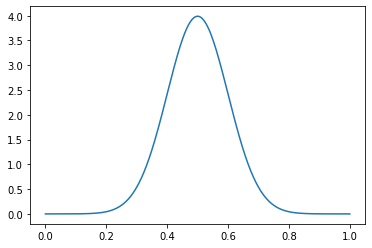

In [66]:
beta_pdf = gaussian_pdf(mu, sigma**2)

x_vis = t.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)

plt.plot(x_vis, y_vis)

visualize a sample sequence

In [ ]:
grid = init_grids(grid_size,1)
beta = t.clip(normal.Normal(mu,sigma).sample(), 0, 1)
sequence = [grid.detach().squeeze()]
for i in range(steps_per_sequence):
  grid = model(grid, beta)
  sequence.append(grid.detach().squeeze())
visualize_sequence(t.stack(sequence), framerate=frame_speed)


for the experiment, we generate 1000 sequences. For each sequence, we draw a beta randomly from the distribution

In [99]:
sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
betas = []

# @title generate dataset
for seq_idx in tqdm(range(num_sequences)):
  sequence = init_grids(grid_size,1)
  beta = t.clip(normal.Normal(mu, sigma).sample(), 0, 1)
  for step_idx in range(steps_per_sequence):
    sequences[seq_idx,step_idx,:,:] = sequence
    sequence = model(sequence, beta)
  betas.append(beta.detach())

dataset = chop_and_shuffle_data(sequences)

100%|██████████| 100/100 [00:00<00:00, 179.21it/s]


Text(0, 0.5, 'density')

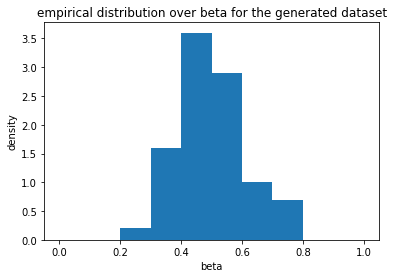

In [100]:
plt.hist(betas, density=True, range=(0,1), bins=10)
plt.title("empirical distribution over beta for the generated dataset")
plt.xlabel("beta")
plt.ylabel("density")

In [101]:
dset = dataset.numpy()
mask = np.all(dset[:,0] == 1, axis=(-1,-2))

num_faulty_entries = mask[mask==True].shape[0]

print(f"remove {num_faulty_entries} entries from the dataset")

dset = np.delete(dset, mask, axis=0)

dataset = t.from_numpy(dset)

print(dataset.size())

remove 40 entries from the dataset
torch.Size([1860, 2, 30, 30])


### Estimate $\beta$ via ABC-REJ

We define:

- $\epsilon = 0.1$ 
- $p(\theta) \sim U(0,1)$

In [16]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

In [17]:
# @title define a rejection sampler function
def ABC_REJ(X:np.ndarray, Y_obs:np.ndarray, epsilon:float) -> float:
  num_steps = 1
  beta = None
  dist_func_jit = jit(calc_distance_V2)
  while True:
    beta = sample_from_prior(1)
    Y_sim = model(X, beta)
    distance = dist_func_jit(X, Y_sim, Y_obs)
    if distance <= epsilon:
      break
    else:
      num_steps += 1
  return beta, num_steps

In [31]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}
samples = []
required_steps = []
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.01

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1_000)):
  sample, num_steps = ABC_REJ(X, Y_obs, epsilon)
  samples.append(sample)
  required_steps.append(num_steps)

print(f"\n average # steps for acceptance: {np.mean(required_steps)}")




100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


 average # steps for acceptance: 5.733


Text(0, 0.5, 'density')

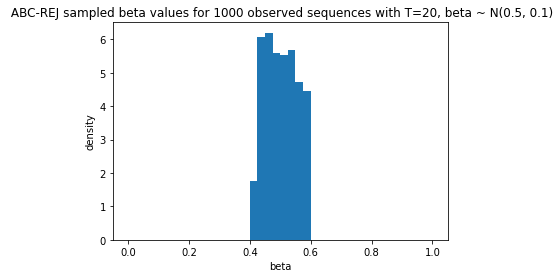

In [32]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(np.array(samples).squeeze(-1), density=True, range=(0,1), bins=40)
plt.title(f" ABC-REJ sampled beta values for 1000 observed sequences with T=20, beta ~ N({mu}, {sigma})")
plt.xlabel("beta")
plt.ylabel("density")

### Estimate $\beta$ via ABC-MCMC

In [45]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

# @title Helper Functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(jnp.sqrt(2*jnp.pi)*jnp.sqrt(sigma_sq)))*jnp.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

def q(mu:float, sigma) -> float:
  return jnp.clip(np.random.normal(mu, sigma), 0, 1)

def gauss_likelihood(x, y, sigma):
  """
  Calculate the likelihood of x as p(x|y) ~ N(y|sigma_sq)
  """
  pdf = gaussian_pdf(y, sigma)
  return pdf(x)

def uniform_likelihood(low:float, high:float, x:float) -> float:
  """
  Calculate the likelihood of x as p(x) ~ U(low, high)
  """
  if x > high or x < low:
    return 0 
  else:
    return 1 / (high-low)

def calc_alpha(beta_star:float, beta:float, epsilon:float, dist:float, sigma:float) -> float:
  if dist <= epsilon and uniform_likelihood(0, 1, beta_star) > 0:
    return min([1,gauss_likelihood(beta, beta_star, sigma)/gauss_likelihood(beta_star, beta, sigma)])
  else:
    return 0

In [46]:
# @title Define ABC-MCMC
def ABC_MCMC(X:np.ndarray, Y_obs:np.ndarray, N:int, epsilon:float, beta:float, proposal_sigma:float) -> List[float]:
  betas = [beta]
  beta_hist = [beta]
  steps_per_sample = 1
  step_hist = []
  for i in tqdm(range(N)):
    beta_star = q(beta, proposal_sigma)
    Y_sim = model(X, beta_star)
    dist = calc_distance_V2(X, Y_sim, Y_obs)
    alpha = calc_alpha(beta_star, beta, epsilon, dist, proposal_sigma)
    if random.random() <= alpha:
      beta = beta_star
      betas.append(beta)
      step_hist.append(steps_per_sample)
      steps_per_sample = 1
    else:
      steps_per_sample += 1
    beta_hist.append(beta)
  return betas, beta_hist, step_hist

100%|██████████| 10000/10000 [10:46<00:00, 15.46it/s]


accepted 7998 samples


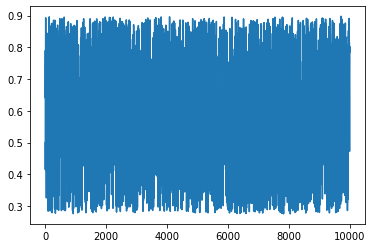

In [23]:
# @title Run ABC-MCMC for the example { vertical-output: true}
N = 10000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1
beta_init = 0.5
proposal_sigma = 0.15

betas, beta_hist, step_hist = ABC_MCMC(X, Y_obs, N, epsilon, beta_init, proposal_sigma)

print(f"accepted {len(betas)} samples")

plt.plot(np.arange(len(beta_hist)), beta_hist)

Text(0, 0.5, 'density')

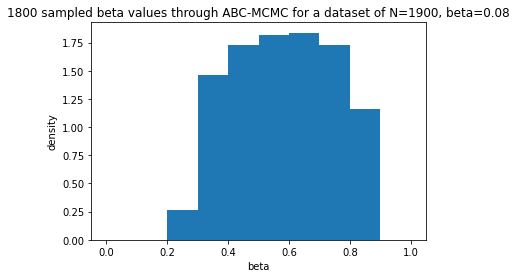

In [28]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(betas, density=True, range=(0,1), bins=10)
plt.title("1800 sampled beta values through ABC-MCMC for a dataset of N=1900, beta=0.08")
plt.xlabel("beta")
plt.ylabel("density")

### Estimate $\beta$ via ABC-PRC

we use:

- A population of $N=1000$ particles
- A sequence of three distributions $f_1, f_2, f_3$ defined through:
$$
f_t(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon_t) = \frac{\pi(\theta)}{B_t} \sum_{b=1}^{B_t} \textbf{1}(\rho(S(x_{(b)}), S(x_{obs})) \leq \epsilon_t)
$$
- $\epsilon_1=0.8, \epsilon_2=0.3, \epsilon_3=0.1$
- $\pi(\theta) \sim U(0,1)$
- $\mu_1(\theta)=\pi(\theta)$
- $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$, gaussian random walks with $\theta_t \sim \mathcal{N}(\theta_{t-1}, 0.1)$

In [17]:
# @title define helper Functions
Sampler = Callable[[int], np.ndarray]

def mu_1(num_samples:int) -> float:
  return np.random.uniform(0, 1, num_samples)

def visualize_results(beta_hist:List[List[float]], mu, sigma) -> None:
  """
  Visualize the results of the ABC-PRJ algorithm.
  """
  beta_pdf = gaussian_pdf(mu, sigma**2)

  x_vis = np.linspace(0,1,1_000)
  y_vis = beta_pdf(x_vis)

  fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

  axs[0,0].hist(beta_hist[0], density=True, bins=30)
  axs[0,0].plot(x_vis, y_vis)
  axs[0,0].set(ylabel='density', title="Population 0")
  axs[0,1].hist(beta_hist[1], density=True, bins=30)
  axs[0,1].plot(x_vis, y_vis)
  axs[0,1].set(title="Population 1")
  axs[1,0].hist(beta_hist[2], density=True, bins=30)
  axs[1,0].plot(x_vis, y_vis)
  axs[1,0].set(xlabel='theta', ylabel='density', title="Population 2")
  axs[1,1].hist(beta_hist[3], density=True, bins=30)
  axs[1,1].plot(x_vis, y_vis)
  axs[1,1].set(xlabel='theta', title="Population 3")

  plt.xlim(0,1)
  plt.show()

In [18]:
# @title Define ABC-PRC
def ABC_PRC(N:int, epsilons:List[float], mu_1:Sampler, X, Y_obs) -> Tuple[List[float], List[List[float]]]:
  betas = mu_1(1000)
  beta_hist = [np.copy(betas)]
  for t, epsilon in enumerate(tqdm(epsilons)):
    for i in range(N):
      close_enough = False
      beta_star = beta_ss = x_ss = None
      while not close_enough:
        # Sample from previous population
        beta_star = np.random.choice(betas, size=1)
        # Move the particle with a gaussian markov kernel
        beta_ss = jnp.clip(np.random.normal(beta_star, 0.1), 0, 1)
        # sample Y_sim using beta**
        Y_sim = model(X, beta_ss)
        # check the distance
        close_enough = calc_distance_V2(X, Y_sim, Y_obs) <= epsilon
      betas[i] = beta_ss.copy()
    beta_hist.append(np.copy(betas))
  return betas, beta_hist

100%|██████████| 3/3 [03:54<00:00, 78.04s/it]


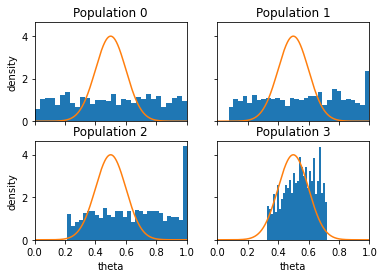

In [22]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 1000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05]

betas, beta_hist = ABC_PRC(N, epsilons, mu_1, X, Y_obs)

visualize_results(beta_hist, mu, sigma)